In [1]:
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

            normal  abnormal
date                        
2011/11/11    4640      6200
2011/11/12    2343      6440
2011/11/13    3213      6440
2011/11/14    4450      4293
2011/11/15    4300      2146


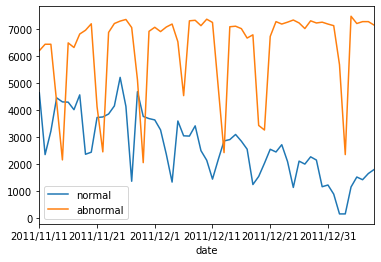

In [2]:
###周期性分析###
power=pd.read_csv('./example/Ele_pow.csv',index_col=0)
print(power.head())
power.plot()

In [4]:
#自定义列向量插值函数
#s为列向量，n为被插值的位置，k为取前后的数据个数，默认为5
def ployinterp_column(s, n, k=5):
  y = s[list(range(n-k, n)) + list(range(n+1, n+1+k))] #取数
  y = y[y.notnull()] #剔除空值
  return lagrange(y.index, list(y))(n) #插值并返回插值结果


In [3]:
###缺失值处理###
from scipy.interpolate import lagrange #导入拉格朗日插值函数

inputfile = './example/missing_data.xls' #输入数据路径,需要使用Excel格式；
outputfile = './example/missing_data_processed.xls' #输出数据路径,需要使用Excel格式

data = pd.read_excel(inputfile, header=None) #读入数据
data

,0,1,2
0,235.8333,324.0343,478.3231
1,236.2708,325.6379,515.4564
2,238.0521,328.0897,517.0909
3,235.9063,NaN,514.8900
4,236.7604,268.8324,NaN
5,NaN,404.0480,486.0912
6,237.4167,391.2652,516.2330
7,238.6563,380.8241,NaN
8,237.6042,388.0230,435.3508
9,238.0313,206.4349,487.6750


In [5]:
for i in data.columns:
    for j in range(len(data)):
        if (data[i].isnull())[j]: #如果为空即插值。
              data[i][j] = ployinterp_column(data[i], j)

/home/blime/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [6]:
data.to_excel(outputfile, header=None, index=False) #输出结果

### 构建模型

In [9]:

def cm_plot(y, yp):
  
  from sklearn.metrics import confusion_matrix

  cm = confusion_matrix(y, yp) 
  
  import matplotlib.pyplot as plt 
  plt.matshow(cm, cmap=plt.cm.Greens) 
  plt.colorbar() 
  
  for x in range(len(cm)): 
    for y in range(len(cm)):
      plt.annotate(cm[x,y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
  
  plt.ylabel('True label') 
  plt.xlabel('Predicted label') 
  return plt

# 构建并测试CART决策树模型

In [18]:
import pandas as pd #导入数据分析库
from random import shuffle #导入随机函数shuffle，用来打算数据

datafile = './example/model.xls' #数据名
data = pd.read_excel(datafile) #读取数据，数据的前三列是特征，第四列是标签
data = data.as_matrix() #将表格转换为矩阵
shuffle(data) #随机打乱数据

/home/blime/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [19]:
p = 0.8 #设置训练数据比例
train = data[:int(len(data)*p),:] #前80%为训练集
test = data[int(len(data)*p):,:] #后20%为测试集

# 构建CART决策树模型

In [22]:
from sklearn.tree import DecisionTreeClassifier #导入决策树模型

treefile = './example/tree.pkl' #模型输出名字
tree = DecisionTreeClassifier() #建立决策树模型
tree.fit(train[:,:3], train[:,3]) #训练

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# 保存模型

In [23]:
from sklearn.externals import joblib
joblib.dump(tree, treefile)

/home/blime/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['./example/tree.pkl']

# 显示混淆矩阵可视化结果

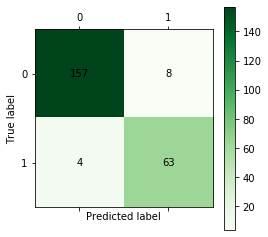

In [24]:
cm_plot(train[:,3], tree.predict(train[:,:3])).show() 
#注意到Scikit-Learn使用predict方法直接给出预测结果。

# ROC曲线

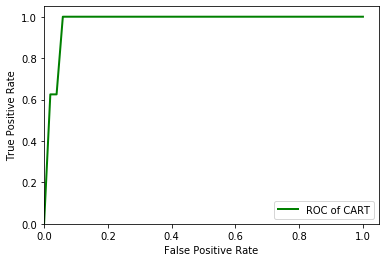

In [25]:
from sklearn.metrics import roc_curve #导入ROC曲线函数

fpr, tpr, thresholds = roc_curve(test[:,3], tree.predict_proba(test[:,:3])[:,1], pos_label=1)
plt.plot(fpr, tpr, linewidth=2, label = 'ROC of CART', color = 'green') #作出ROC曲线
plt.xlabel('False Positive Rate') #坐标轴标签
plt.ylabel('True Positive Rate') #坐标轴标签
plt.ylim(0,1.05) #边界范围
plt.xlim(0,1.05) #边界范围
plt.legend(loc=4) #图例
plt.show() #显示作图结果

# 构建神经网络模型

In [32]:
import pandas as pd
from random import shuffle

datafile = './example/model.xls'
data = pd.read_excel(datafile)
data = data.as_matrix()
shuffle(data)

p = 0.8 #设置训练数据比例
train = data[:int(len(data)*p),:]
test = data[int(len(data)*p):,:]

/home/blime/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [33]:
from keras.models import Sequential #导入神经网络初始化函数
from keras.layers.core import Dense, Activation #导入神经网络层函数、激活函数

netfile = './example/net.model' #构建的神经网络模型存储路径

Using TensorFlow backend.
/home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/blime/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/blime/anaconda3/lib/python3.7/site-packages/tensorflo

In [34]:
net = Sequential() #建立神经网络
net.add(Dense(10,input_dim=3)) #添加输入层（3节点）到隐藏层（10节点）的连接
net.add(Activation('relu')) #隐藏层使用relu激活函数
net.add(Dense(1,input_dim=10)) #添加隐藏层（10节点）到输出层（1节点）的连接
net.add(Activation('sigmoid')) #输出层使用sigmoid激活函数
net.compile(loss = 'binary_crossentropy', optimizer = 'adam') #编译模型，使用adam方法求解

W0710 14:44:12.350214 140044340365120 deprecation_wrapper.py:119] From /home/blime/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 14:44:12.386354 140044340365120 deprecation_wrapper.py:119] From /home/blime/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 14:44:12.394416 140044340365120 deprecation_wrapper.py:119] From /home/blime/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 14:44:12.426784 140044340365120 deprecation_wrapper.py:119] From /home/blime/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0710 14:44:

In [35]:
net.fit(train[:,:3], train[:,3], nb_epoch=1000, batch_size=1) #训练模型，循环1000次
net.save_weights(netfile)

/home/blime/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.
W0710 14:47:23.205608 140044340365120 deprecation_wrapper.py:119] From /home/blime/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.7685
Epoch 2/1000
232/232 [==============================] - 0s 880us/step - loss: 0.6671
Epoch 3/1000
232/232 [==============================] - 0s 798us/step - loss: 0.6130
Epoch 4/1000
232/232 [==============================] - 0s 753us/step - loss: 0.5681
Epoch 5/1000
232/232 [==============================] - 0s 718us/step - loss: 0.5318
Epoch 6/1000
232/232 [==============================] - 0s 767us/step - loss: 0.5032
Epoch 7/1000
232/232 [==============================] - 0s 690us/step - loss: 0.4819
Epoch 8/1000
232/232 [==============================] - 0s 690us/step - loss: 0.4612
Epoch 9/1000
232/232 [==============================] - 0s 765us/step - loss: 0.4415
Epoch 10/1000
232/232 [==============================] - 0s 727us/step - loss: 0.4263
Epoch 11/1000
232/232 [==============================] - 0s 733us/step - loss: 0.4115
Epoch 12/1000
232/232 [==============================] - 0s 737us

232/232 [==============================] - 0s 720us/step - loss: 0.2653
Epoch 97/1000
232/232 [==============================] - 0s 702us/step - loss: 0.2661
Epoch 98/1000
232/232 [==============================] - 0s 697us/step - loss: 0.2653
Epoch 99/1000
232/232 [==============================] - 0s 691us/step - loss: 0.2648
Epoch 100/1000
232/232 [==============================] - 0s 695us/step - loss: 0.2665
Epoch 101/1000
232/232 [==============================] - 0s 682us/step - loss: 0.2655
Epoch 102/1000
232/232 [==============================] - 0s 724us/step - loss: 0.2644
Epoch 103/1000
232/232 [==============================] - 0s 712us/step - loss: 0.2622
Epoch 104/1000
232/232 [==============================] - 0s 767us/step - loss: 0.2644
Epoch 105/1000
232/232 [==============================] - 0s 690us/step - loss: 0.2642
Epoch 106/1000
232/232 [==============================] - 0s 680us/step - loss: 0.2649
Epoch 107/1000
232/232 [==============================] - 0s 

232/232 [==============================] - 0s 762us/step - loss: 0.2501
Epoch 191/1000
232/232 [==============================] - 0s 754us/step - loss: 0.2509
Epoch 192/1000
232/232 [==============================] - 0s 748us/step - loss: 0.2523
Epoch 193/1000
232/232 [==============================] - 0s 751us/step - loss: 0.2529
Epoch 194/1000
232/232 [==============================] - 0s 771us/step - loss: 0.2521
Epoch 195/1000
232/232 [==============================] - 0s 747us/step - loss: 0.2506
Epoch 196/1000
232/232 [==============================] - 0s 742us/step - loss: 0.2497
Epoch 197/1000
232/232 [==============================] - 0s 753us/step - loss: 0.2525
Epoch 198/1000
232/232 [==============================] - 0s 744us/step - loss: 0.2527
Epoch 199/1000
232/232 [==============================] - 0s 763us/step - loss: 0.2505
Epoch 200/1000
232/232 [==============================] - 0s 749us/step - loss: 0.2500
Epoch 201/1000
232/232 [==============================] - 

232/232 [==============================] - 0s 755us/step - loss: 0.2316
Epoch 285/1000
232/232 [==============================] - 0s 771us/step - loss: 0.2330
Epoch 286/1000
232/232 [==============================] - 0s 634us/step - loss: 0.2347
Epoch 287/1000
232/232 [==============================] - 0s 683us/step - loss: 0.2349
Epoch 288/1000
232/232 [==============================] - 0s 741us/step - loss: 0.2322
Epoch 289/1000
232/232 [==============================] - 0s 690us/step - loss: 0.2326
Epoch 290/1000
232/232 [==============================] - 0s 653us/step - loss: 0.2325
Epoch 291/1000
232/232 [==============================] - 0s 648us/step - loss: 0.2329
Epoch 292/1000
232/232 [==============================] - 0s 685us/step - loss: 0.2320
Epoch 293/1000
232/232 [==============================] - 0s 723us/step - loss: 0.2315
Epoch 294/1000
232/232 [==============================] - 0s 729us/step - loss: 0.2323
Epoch 295/1000
232/232 [==============================] - 

232/232 [==============================] - 0s 711us/step - loss: 0.2279
Epoch 379/1000
232/232 [==============================] - 0s 701us/step - loss: 0.2303
Epoch 380/1000
232/232 [==============================] - 0s 696us/step - loss: 0.2289
Epoch 381/1000
232/232 [==============================] - 0s 710us/step - loss: 0.2291
Epoch 382/1000
232/232 [==============================] - 0s 726us/step - loss: 0.2283
Epoch 383/1000
232/232 [==============================] - 0s 746us/step - loss: 0.2270
Epoch 384/1000
232/232 [==============================] - 0s 748us/step - loss: 0.2334
Epoch 385/1000
232/232 [==============================] - 0s 728us/step - loss: 0.2289
Epoch 386/1000
232/232 [==============================] - 0s 744us/step - loss: 0.2294
Epoch 387/1000
232/232 [==============================] - 0s 755us/step - loss: 0.2273
Epoch 388/1000
232/232 [==============================] - 0s 716us/step - loss: 0.2280
Epoch 389/1000
232/232 [==============================] - 

232/232 [==============================] - 0s 858us/step - loss: 0.2294
Epoch 473/1000
232/232 [==============================] - 0s 839us/step - loss: 0.2266
Epoch 474/1000
232/232 [==============================] - 0s 842us/step - loss: 0.2285
Epoch 475/1000
232/232 [==============================] - 0s 751us/step - loss: 0.2258
Epoch 476/1000
232/232 [==============================] - 0s 752us/step - loss: 0.2262
Epoch 477/1000
232/232 [==============================] - 0s 769us/step - loss: 0.2261
Epoch 478/1000
232/232 [==============================] - 0s 748us/step - loss: 0.2261
Epoch 479/1000
232/232 [==============================] - 0s 1ms/step - loss: 0.2282
Epoch 480/1000
232/232 [==============================] - 0s 693us/step - loss: 0.2276
Epoch 481/1000
232/232 [==============================] - 0s 770us/step - loss: 0.2276
Epoch 482/1000
232/232 [==============================] - 0s 740us/step - loss: 0.2259
Epoch 483/1000
232/232 [==============================] - 0s

232/232 [==============================] - 0s 774us/step - loss: 0.2080
Epoch 567/1000
232/232 [==============================] - 0s 744us/step - loss: 0.2082
Epoch 568/1000
232/232 [==============================] - 0s 1ms/step - loss: 0.2054
Epoch 569/1000
232/232 [==============================] - 0s 1ms/step - loss: 0.2078
Epoch 570/1000
232/232 [==============================] - 0s 700us/step - loss: 0.2063
Epoch 571/1000
232/232 [==============================] - 0s 768us/step - loss: 0.2054
Epoch 572/1000
232/232 [==============================] - 0s 1ms/step - loss: 0.2057
Epoch 573/1000
232/232 [==============================] - 0s 1ms/step - loss: 0.2070
Epoch 574/1000
232/232 [==============================] - 0s 1ms/step - loss: 0.2057
Epoch 575/1000
232/232 [==============================] - 0s 761us/step - loss: 0.2046
Epoch 576/1000
232/232 [==============================] - 0s 916us/step - loss: 0.2051
Epoch 577/1000
232/232 [==============================] - 0s 867us/s

232/232 [==============================] - 0s 709us/step - loss: 0.1821
Epoch 661/1000
232/232 [==============================] - 0s 711us/step - loss: 0.1785
Epoch 662/1000
232/232 [==============================] - 0s 695us/step - loss: 0.1813
Epoch 663/1000
232/232 [==============================] - 0s 713us/step - loss: 0.1789
Epoch 664/1000
232/232 [==============================] - 0s 728us/step - loss: 0.1781
Epoch 665/1000
232/232 [==============================] - 0s 718us/step - loss: 0.1793
Epoch 666/1000
232/232 [==============================] - 0s 715us/step - loss: 0.1778
Epoch 667/1000
232/232 [==============================] - 0s 734us/step - loss: 0.1772
Epoch 668/1000
232/232 [==============================] - 0s 714us/step - loss: 0.1787
Epoch 669/1000
232/232 [==============================] - 0s 705us/step - loss: 0.1767
Epoch 670/1000
232/232 [==============================] - 0s 708us/step - loss: 0.1784
Epoch 671/1000
232/232 [==============================] - 

232/232 [==============================] - 0s 703us/step - loss: 0.1575
Epoch 755/1000
232/232 [==============================] - 0s 699us/step - loss: 0.1567
Epoch 756/1000
232/232 [==============================] - 0s 711us/step - loss: 0.1556
Epoch 757/1000
232/232 [==============================] - 0s 770us/step - loss: 0.1571
Epoch 758/1000
232/232 [==============================] - 0s 679us/step - loss: 0.1557
Epoch 759/1000
232/232 [==============================] - 0s 668us/step - loss: 0.1545
Epoch 760/1000
232/232 [==============================] - 0s 726us/step - loss: 0.1550
Epoch 761/1000
232/232 [==============================] - 0s 725us/step - loss: 0.1574
Epoch 762/1000
232/232 [==============================] - 0s 723us/step - loss: 0.1569
Epoch 763/1000
232/232 [==============================] - 0s 690us/step - loss: 0.1547
Epoch 764/1000
232/232 [==============================] - 0s 821us/step - loss: 0.1553
Epoch 765/1000
232/232 [==============================] - 

232/232 [==============================] - 0s 702us/step - loss: 0.1360
Epoch 849/1000
232/232 [==============================] - 0s 706us/step - loss: 0.1343
Epoch 850/1000
232/232 [==============================] - 0s 700us/step - loss: 0.1402
Epoch 851/1000
232/232 [==============================] - 0s 697us/step - loss: 0.1378
Epoch 852/1000
232/232 [==============================] - 0s 715us/step - loss: 0.1362
Epoch 853/1000
232/232 [==============================] - 0s 705us/step - loss: 0.1332
Epoch 854/1000
232/232 [==============================] - 0s 707us/step - loss: 0.1348
Epoch 855/1000
232/232 [==============================] - 0s 696us/step - loss: 0.1360
Epoch 856/1000
232/232 [==============================] - 0s 725us/step - loss: 0.1329
Epoch 857/1000
232/232 [==============================] - 0s 697us/step - loss: 0.1326
Epoch 858/1000
232/232 [==============================] - 0s 698us/step - loss: 0.1316
Epoch 859/1000
232/232 [==============================] - 

232/232 [==============================] - 0s 686us/step - loss: 0.1241
Epoch 943/1000
232/232 [==============================] - 0s 686us/step - loss: 0.1262
Epoch 944/1000
232/232 [==============================] - 0s 685us/step - loss: 0.1249
Epoch 945/1000
232/232 [==============================] - 0s 692us/step - loss: 0.1247
Epoch 946/1000
232/232 [==============================] - 0s 690us/step - loss: 0.1246
Epoch 947/1000
232/232 [==============================] - 0s 685us/step - loss: 0.1252
Epoch 948/1000
232/232 [==============================] - 0s 695us/step - loss: 0.1255
Epoch 949/1000
232/232 [==============================] - 0s 688us/step - loss: 0.1259
Epoch 950/1000
232/232 [==============================] - 0s 689us/step - loss: 0.1278
Epoch 951/1000
232/232 [==============================] - 0s 688us/step - loss: 0.1270
Epoch 952/1000
232/232 [==============================] - 0s 709us/step - loss: 0.1242
Epoch 953/1000
232/232 [==============================] - 

In [37]:
predict_result = net.predict_classes(train[:,:3]).reshape(len(train)) #预测结果变形
'''这里要提醒的是，keras用predict给出预测概率，predict_classes才是给出预测类别，而且两者的预测结果都是n x 1维数组，而不是通常的 1 x n'''
predict_result

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

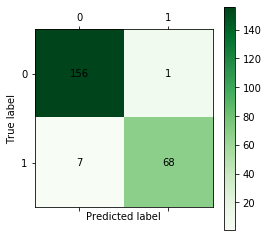

In [38]:
cm_plot(train[:,3], predict_result).show() #显示混淆矩阵可视化结果

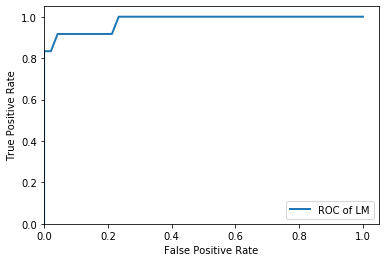

In [39]:
from sklearn.metrics import roc_curve #导入ROC曲线函数

predict_result = net.predict(test[:,:3]).reshape(len(test))
fpr, tpr, thresholds = roc_curve(test[:,3], predict_result, pos_label=1)
plt.plot(fpr, tpr, linewidth=2, label = 'ROC of LM') #作出ROC曲线
plt.xlabel('False Positive Rate') #坐标轴标签
plt.ylabel('True Positive Rate') #坐标轴标签
plt.ylim(0,1.05) #边界范围
plt.xlim(0,1.05) #边界范围
plt.legend(loc=4) #图例
plt.show() #显示作图结果  